In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torchvision import transforms, datasets
from mup.shape import set_base_shapes
from torch import nn
from torch.nn import Linear
from mup.layer import MuReadout
from functools import partial
from mup.init import (kaiming_normal_, kaiming_uniform_, normal_,
                         trunc_normal_, uniform_, xavier_normal_,
                         xavier_uniform_)
from mup.coord_check import plot_coord_data, _record_coords
from torch.nn.modules.conv import _ConvNd

from copy import copy
from itertools import product
from functools import partial

sns.set_theme()

In [2]:
samplers = {
    'default': lambda x: x,
    'const_uniform': partial(uniform_, a=-0.1, b=0.1),
    'const_normal': partial(normal_, std=0.1),
    'const_trunc_normal': partial(trunc_normal_, std=0.1, a=-0.2, b=0.2),
    'xavier_uniform': xavier_uniform_,
    'xavier_normal': xavier_normal_,
    'kaiming_fan_in_uniform': partial(kaiming_uniform_, mode='fan_in'),
    'kaiming_fan_in_normal': partial(kaiming_normal_, mode='fan_in'),
    'kaiming_fan_out_uniform': partial(kaiming_uniform_, mode='fan_out'),
    'kaiming_fan_out_normal': partial(kaiming_normal_, mode='fan_out')
}


def init_model(model, sampler):
    for param in model.parameters():
        if len(param.shape) >= 2:
            sampler(param)
    return model

init_methods = {
    k: partial(init_model, sampler=s) for k, s in samplers.items()
}

def _generate_MLP(width, bias=True, mup=True, batchnorm=False, device='cpu'):
    mods = [Linear(3072, width, bias=bias, device=device),
            nn.ReLU(),
            Linear(width, width, bias=bias, device=device),
            nn.ReLU()
    ]
    if mup:
        mods.append(MuReadout(width, 10, bias=bias, readout_zero_init=False, device=device))
    else:
        mods.append(Linear(width, 10, bias=bias, device=device))
    if batchnorm:
        mods.insert(1, nn.BatchNorm1d(width, device=device))
        mods.insert(4, nn.BatchNorm1d(width, device=device))
    model = nn.Sequential(*mods)
    return model

def generate_MLP(width, bias=True, mup=True, readout_zero_init=True, batchnorm=False, init='default', bias_zero_init=False, base_width=256):
    if not mup:
        model = _generate_MLP(width, bias, mup, batchnorm)
        # set base shapes to model's own shapes, so we get SP
        return set_base_shapes(model, None)
    # it's important we make `model` first, because of random seed
    model = _generate_MLP(width, bias, mup, batchnorm)
    base_model = _generate_MLP(base_width, bias, mup, batchnorm, device='meta')
    set_base_shapes(model, base_model)
    init_methods[init](model)
    if readout_zero_init:
        readout = list(model.modules())[-1]
        readout.weight.data.zero_()
        if readout.bias is not None:
            readout.bias.data.zero_()
    if bias_zero_init:
        for module in model.modules():
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
    return model


def _generate_CNN(width, bias=True, mup=True, batchnorm=False, device='cpu'):
    mods = [
        nn.Conv2d(3, width, kernel_size=5, bias=bias, device=device),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(width, 2*width, kernel_size=5, bias=bias, device=device),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(2*width*25, width*16, bias=bias, device=device),
        nn.ReLU(inplace=True),
        nn.Linear(width*16, width*10, bias=bias, device=device),
        nn.ReLU(inplace=True),
    ]
    if mup:
        mods.append(MuReadout(width*10, 10, bias=bias, readout_zero_init=False, device=device))
    else:
        mods.append(nn.Linear(width*10, 10, bias=bias, device=device))
    if batchnorm:
        mods.insert(1, nn.BatchNorm2d(width, device=device))
        mods.insert(5, nn.BatchNorm2d(2*width, device=device))
        mods.insert(10, nn.BatchNorm1d(16*width, device=device))
        mods.insert(13, nn.BatchNorm1d(10*width, device=device))
    return nn.Sequential(*mods)

def generate_CNN(width, bias=True, mup=True, readout_zero_init=True, batchnorm=False, init='default', bias_zero_init=False, base_width=8):
    if not mup:
        model = _generate_CNN(width, bias, mup, batchnorm)
        # set base shapes to model's own shapes, so we get SP
        return set_base_shapes(model, None)
    # it's important we make `model` first, because of random seed
    model = _generate_CNN(width, bias, mup, batchnorm)
    base_model = _generate_CNN(base_width, bias, mup, batchnorm, device='meta')
    set_base_shapes(model, base_model)
    init_methods[init](model)
    if readout_zero_init:
        readout = list(model.modules())[-1]
        readout.weight.data.zero_()
        if readout.bias is not None:
            readout.bias.data.zero_()
    if bias_zero_init:
        for module in model.modules():
            if isinstance(module, (nn.Linear, _ConvNd)) and module.bias is not None:
                module.bias.data.zero_()
    return model

def get_lazy_models(arch, widths, mup=True, init='kaiming_fan_in_normal', readout_zero_init=True, batchnorm=True, base_width=None):
    '''if mup is False, then `init`, `readout_zero_init`, `base_width` don't matter.'''
    if arch == 'mlp':
        base_width = base_width or 256
        generate = generate_MLP
    elif arch == 'cnn':
        base_width = base_width or 8
        generate = generate_CNN
    def gen(w):
        def f():
            model = generate(w, mup=mup, init=init, readout_zero_init=readout_zero_init, batchnorm=batchnorm, base_width=base_width)
            return model
        return f
    return {w: gen(w) for w in widths}


def get_train_loader(batch_size, num_workers=0, shuffle=False, train=True, download=False):

    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = datasets.CIFAR10(root='dataset', train=train,
                                download=download, transform=transform)
    return torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                shuffle=shuffle, num_workers=num_workers)

In [3]:
import math
def _get_coord_data(models, dataloader, optcls, nsteps=3,
                dict_in_out=False, flatten_input=False, flatten_output=False, 
                output_name='loss', lossfn='xent', filter_module_by_name=None,
                fix_data=True, cuda=True, nseeds=1, 
                output_fdict=None, input_fdict=None, param_fdict=None,
                show_progress=True):
    '''Inner method for `get_coord_data`.

    Train the models in `models` with optimizer given by `optcls` and data from
    `dataloader` for `nsteps` steps, and record coordinate statistics specified
    by `output_fdict`, `input_fdict`, `param_fdict`. By default, only `l1` is
    computed for output activations of each module.

    Inputs:
        models: 
            a dict of lazy models, where the keys are numbers indicating width.
            Each entry of `models` is a function that instantiates a model given
            nothing.
        dataloader:
            an iterator whose elements are either Huggingface style dicts, if
            `dict_in_out` is True, or (input, label). If `fix_data` is True
            (which is the default), then only the first element of `dataloader`
            is used in a loop and the rest of `dataloder` is ignored.
        optcls: 
            a function so that `optcls(model)` gives an optimizer used to train
            the model.
        nsteps: 
            number of steps to train the model
        dict_in_out:
            whether the data loader contains Huggingface-style dict input and
            output. Default: False
        flatten_input:
            if not `dict_in_out`, reshape the input to be
            `input.view(input.shape[0], -1)`. Typically used for testing MLPs.
        flatten_output:
            if not `dict_in_out`, reshape the label to be `label.view(-1,
            input.shape[-1])`.
        output_name:
            if `dict_in_out`, this is the key for the loss value if the output
            is a dict. If the output is not a dict, then we assume the first
            element of the output is the loss.
        lossfn:
            loss function to use if not `dict_in_out`. Default is `xent` for
            cross entropy loss. Other choices are ['mse', 'nll']
        filter_module_by_name:
            a function that returns a bool given module names (from
            `model.named_modules()`), or None. If not None, then only modules
            whose name yields True will be recorded.
        cuda:
            whether to use cuda or not. Default: True
        nseeds:
            number of times to repeat the training, each with different seeds.
        output_fdict, input_fdict, param_fdict: 
            function dicts to be used in `_record_coords`. By default, only `l1`
            is computed for output activations of each module.
        show_progress:
            show progress using tqdm.
    Output:
        a pandas DataFrame containing recorded results. The column names are
        `'width', 'module', 't'` as well as names of statistics recorded, such
        as `'l1'` (see `FDICT` for other premade statistics that can be
        collected).
    '''
    df = []
    if fix_data:
        batch = next(iter(dataloader))
        dataloader = [batch] * nsteps
    if show_progress:
        from tqdm import tqdm
        pbar = tqdm(total=nseeds * len(models))

    for i in range(nseeds):
        torch.manual_seed(i)
        for width, model in models.items():
            model = model()
            model = model.train()
            if cuda:
                model = model.cuda()
            optimizer = optcls(model)
            for batch_idx, batch in enumerate(dataloader, 1):
                remove_hooks = []
                # add hooks
                for name, module in model.named_modules():
                    if filter_module_by_name and not filter_module_by_name(name):
                        continue
                    remove_hooks.append(module.register_forward_hook(
                        _record_coords(df, width, name, batch_idx,
                            output_fdict=output_fdict,
                            input_fdict=input_fdict,
                            param_fdict=param_fdict)))
                if dict_in_out:
                    if cuda:
                        for k, v in batch.items():
                            if isinstance(v, torch.Tensor):
                                batch[k] = v.cuda()
                    outputs = model(**batch)
                    loss = outputs[output_name] if isinstance(outputs, dict) else outputs[0]
                else:
                    (data, target) = batch
                    if cuda:
                        data, target = data.cuda(), target.cuda()
                    if flatten_input:
                        data = data.view(data.size(0), -1)
                    output = model(data)
                    if flatten_output:
                        output = output.view(-1, output.shape[-1])
                    if lossfn == 'xent':
                        loss = F.cross_entropy(output, target)
                    elif lossfn == 'mse':
                        loss = F.mse_loss(output, F.one_hot(target, num_classes=output.size(-1)).float())
                    elif lossfn == 'nll':
                        loss = F.nll_loss(output, target)
                    else:
                        raise NotImplementedError()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # remove hooks
                for handle in remove_hooks:
                    handle.remove()

                if batch_idx == nsteps: break
            if show_progress:
                pbar.update(1)

    if show_progress:
        pbar.close()
    return pd.DataFrame(df)

def get_coord_data(models, dataloader, optimizer='sgd', lr=None, mup=True,
                    filter_trainable_by_name=None,
                    **kwargs):
    '''Get coord data for coord check.

    Train the models in `models` with data from `dataloader` and optimizer
    specified by `optimizer` and `lr` for `nsteps` steps, and record coordinate
    statistics specified by `output_fdict`, `input_fdict`, `param_fdict`. By
    default, only `l1` is computed for output activations of each module.

    This function wraps around `_get_coord_data`, with the main difference being
    user can specify common optimizers via a more convenient interface.

    Inputs:
        models: 
            a dict of lazy models, where the keys are numbers indicating width.
            Each entry of `models` is a function that instantiates a model given
            nothing.
        dataloader:
            an iterator whose elements are either Huggingface style dicts, if
            `dict_in_out` is True, or (input, label). If `fix_data` is True
            (which is the default), then only the first element of `dataloader`
            is used in a loop and the rest of `dataloder` is ignored.
        optimizer:
            a string in `['sgd', 'adam', 'adamw']`, with default being `'sgd'`.
        lr: 
            learning rate. By default is 0.1 for `'sgd'` and 1e-3 for others.
        mup: 
            If True, then use the optimizer from `mup.optim`; otherwise, use the
            one from `torch.optim`.
        filter_trainable_by_name: 
            a function that returns a bool given module names (from
            `model.named_modules()`), or None. If not None, then only modules
            whose name yields True will be trained.
        nsteps: 
            number of steps to train the model
        dict_in_out:
            whether the data loader contains Huggingface-style dict input and
            output. Default: False
        flatten_input:
            if not `dict_in_out`, reshape the input to be
            `input.view(input.shape[0], -1)`. Typically used for testing MLPs.
        flatten_output:
            if not `dict_in_out`, reshape the label to be `label.view(-1,
            input.shape[-1])`.
        output_name:
            if `dict_in_out`, this is the key for the loss value if the output
            is a dict. If the output is not a dict, then we assume the first
            element of the output is the loss.
        lossfn:
            loss function to use if not `dict_in_out`. Default is `xent` for
            cross entropy loss. Other choices are ['mse', 'nll']
        filter_module_by_name:
            a function that returns a bool given module names (from
            `model.named_modules()`), or None. If not None, then only modules
            whose name yields True will be recorded.
        cuda:
            whether to use cuda or not. Default: True
        nseeds:
            number of times to repeat the training, each with different seeds.
        output_fdict, input_fdict, param_fdict: 
            function dicts to be used in `_record_coords`. By default, only `l1`
            is computed for output activations of each module.
        show_progress:
            show progress using tqdm.
    Output:
        a pandas DataFrame containing recorded results. The column names are
        `'width', 'module', 't'` as well as names of statistics recorded, such
        as `'l1'` (see `FDICT` for other premade statistics that can be
        collected).
    '''
    if lr is None:
        lr = 0.1 if optimizer == 'sgd' else 1e-3
    if mup:
        from mup.optim import MuAdam as Adam
        from mup.optim import MuAdamW as AdamW
        from mup.optim import MuSGD as SGD
    else:
        from torch.optim import SGD, Adam, AdamW
    def get_trainable(model):
        params = model.parameters()
        if filter_trainable_by_name is not None:
            params = []
            for name, p in model.named_parameters():
                if filter_trainable_by_name(name):
                    params.append(p)
        return params
    if optimizer == 'sgd':
        optcls = lambda model: SGD(get_trainable(model), lr=lr)
    elif optimizer == 'adam':
        optcls = lambda model: Adam(get_trainable(model), lr=lr)
    elif optimizer == 'adamw':
        optcls = lambda model: AdamW(get_trainable(model), lr=lr)
    elif optimizer is None:
        raise ValueError('optimizer should be sgd|adam|adamw or a custom function')
    
    data = _get_coord_data(models, dataloader, optcls, **kwargs)
    data['optimizer'] = optimizer
    data['lr'] = lr
    return data

In [ ]:
def example_plot_coord_check(
    arch='mlp', optimizer='sgd', lr=None, widths=None, mup=True,
    nsteps=3, nseeds=10, plotdir='', batchnorm=False, batch_size=1,
    init='kaiming_fan_in_normal', download_cifar=True, legend='full',
    dict_in_out=False, name_contains=None, name_not_contains=None, models=None, train_loader=None):

    if batchnorm:
        batch_size = 5
    if train_loader is None:
        train_loader = get_train_loader(batch_size=batch_size, download=download_cifar)

    if widths is None:
        widths = 2**np.arange(7, 14) if arch == 'mlp' else 2**np.arange(3, 10)
    if models is None:
        models = get_lazy_models(arch, widths, mup=mup, batchnorm=batchnorm, init=init, readout_zero_init=True)
    df = get_coord_data(models, train_loader, mup=mup, lr=lr, optimizer=optimizer, flatten_input=arch == 'mlp', nseeds=nseeds, nsteps=nsteps, dict_in_out=dict_in_out)

    prm = 'μP' if mup else 'SP'
    bn = 'on' if batchnorm else 'off'
    if lr is None:
        lr = 0.1 if optimizer == 'sgd' else 1e-3
    return plot_coord_data(df, legend=legend,
        name_contains=name_contains, name_not_contains=name_not_contains, 
        save_to=os.path.join(plotdir, f'{prm.lower()}_{arch}_{optimizer}_lr{lr}_nseeds{nseeds}_bn{int(batchnorm)}_coord.png'),
        suptitle=f'{prm} {arch.upper()} {optimizer} lr={lr} bn={bn} nseeds={nseeds}',
        face_color='xkcd:light grey' if not mup else None)

100%|██████████| 35/35 [00:03<00:00,  9.39it/s]


coord check plot saved to coord_checks/sp_mlp_sgd_lr0.1_nseeds5_bn0_coord.png


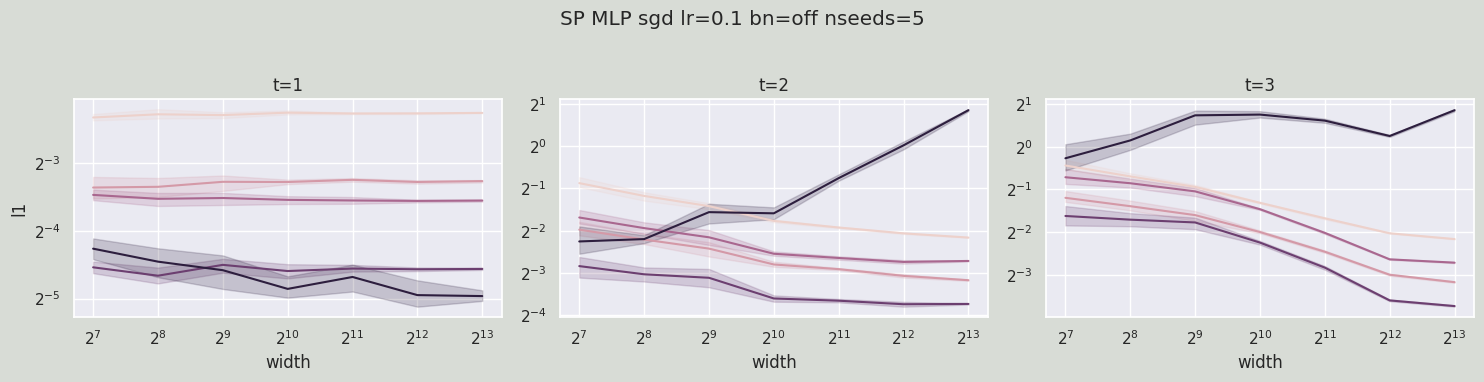

100%|██████████| 35/35 [00:05<00:00,  6.38it/s]


coord check plot saved to coord_checks/μp_mlp_sgd_lr0.1_nseeds5_bn0_coord.png


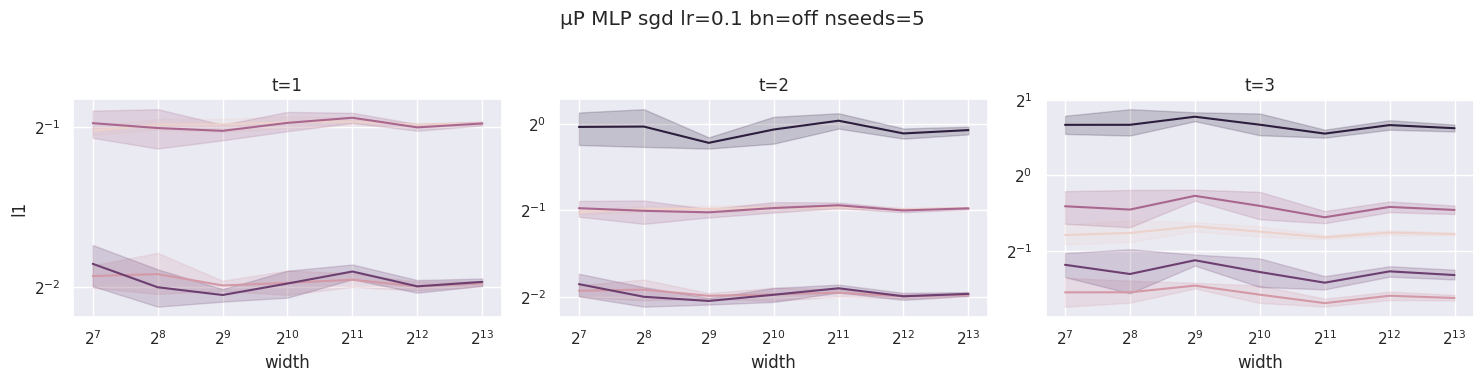

100%|██████████| 35/35 [00:01<00:00, 24.13it/s] 


coord check plot saved to coord_checks/sp_mlp_sgd_lr0.1_nseeds5_bn1_coord.png


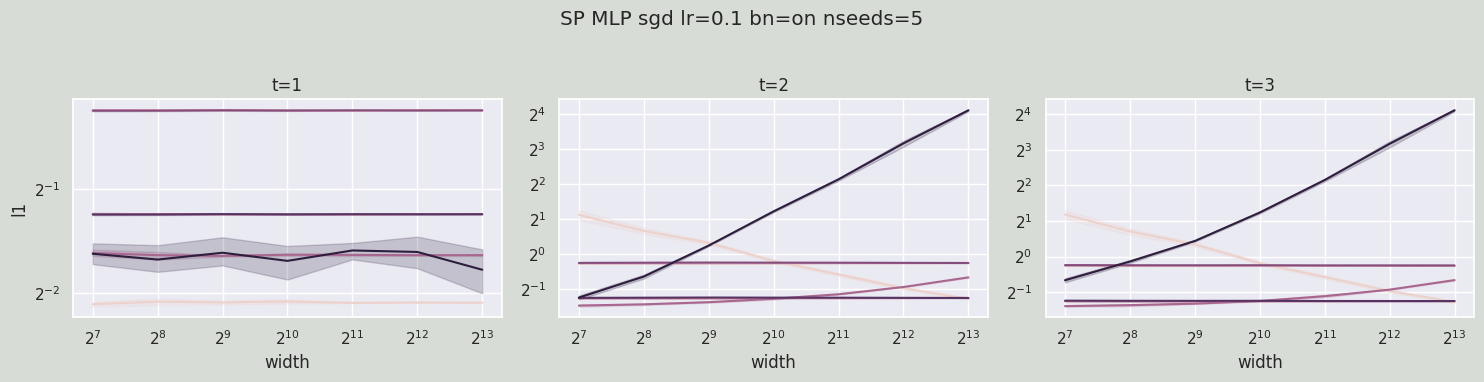

100%|██████████| 35/35 [00:05<00:00,  6.34it/s]


coord check plot saved to coord_checks/μp_mlp_sgd_lr0.1_nseeds5_bn1_coord.png


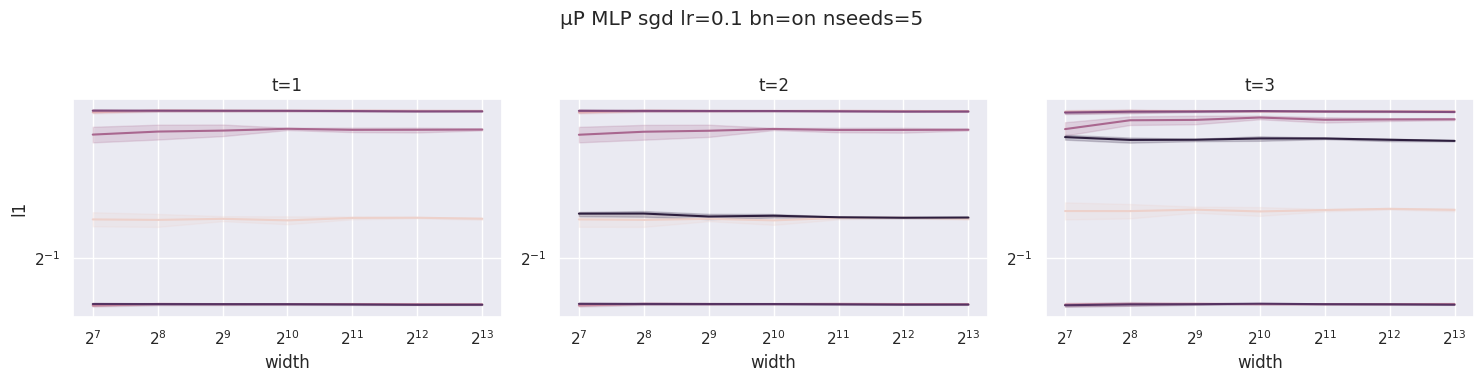

100%|██████████| 35/35 [00:03<00:00, 10.27it/s]


coord check plot saved to coord_checks/sp_mlp_adam_lr0.001_nseeds5_bn0_coord.png


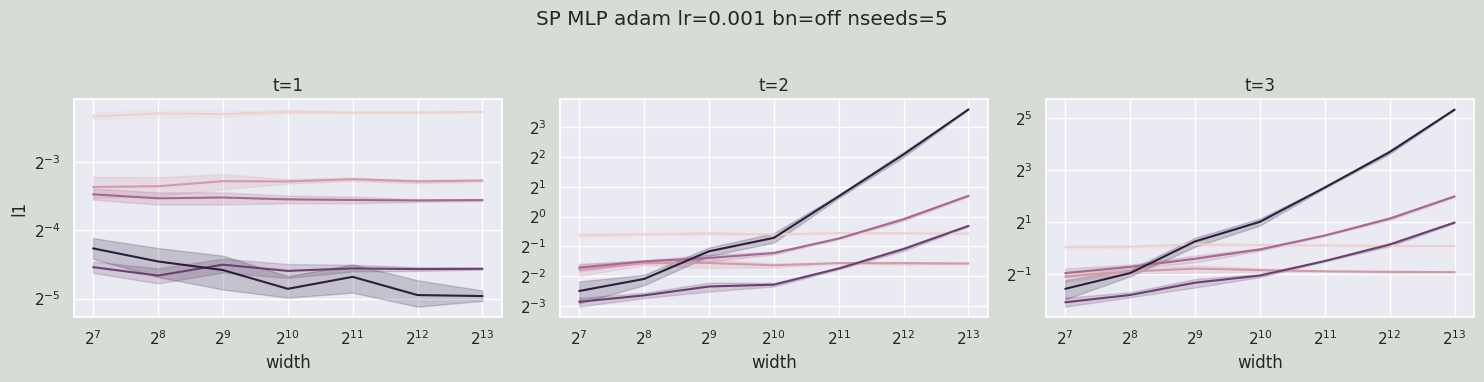

100%|██████████| 35/35 [00:05<00:00,  6.24it/s]


coord check plot saved to coord_checks/μp_mlp_adam_lr0.001_nseeds5_bn0_coord.png


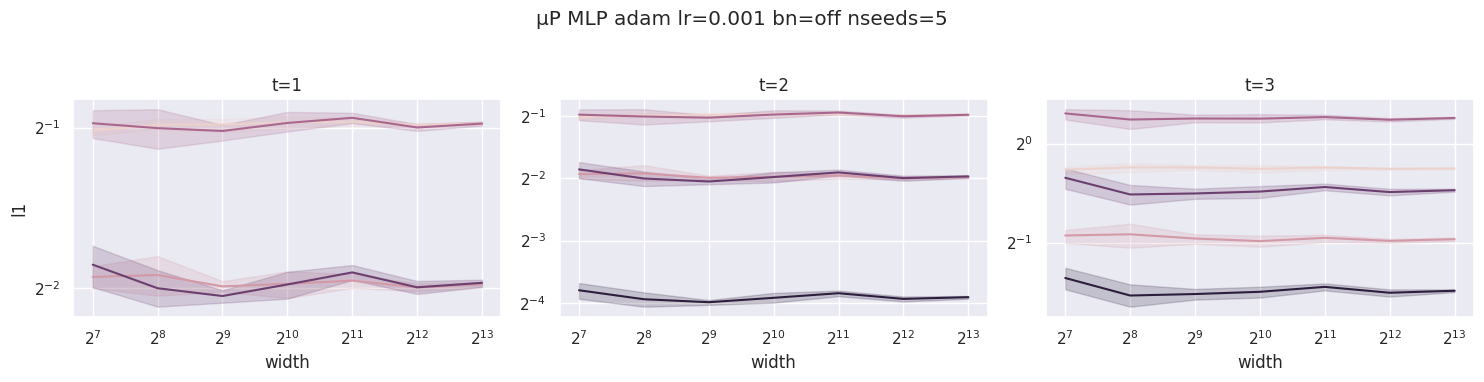

100%|██████████| 35/35 [00:03<00:00, 10.41it/s]


coord check plot saved to coord_checks/sp_mlp_adam_lr0.001_nseeds5_bn1_coord.png


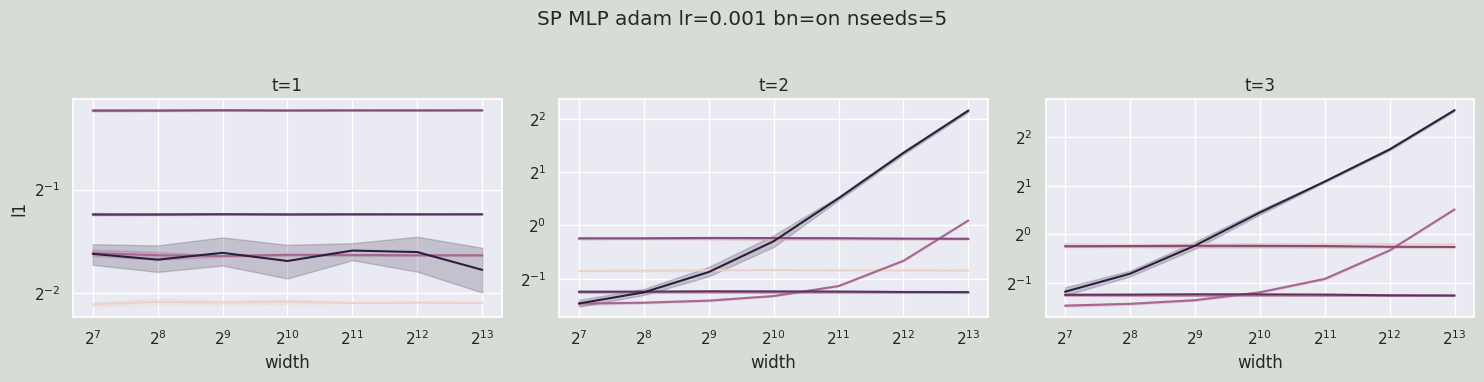

100%|██████████| 35/35 [00:03<00:00,  9.46it/s]


coord check plot saved to coord_checks/μp_mlp_adam_lr0.001_nseeds5_bn1_coord.png


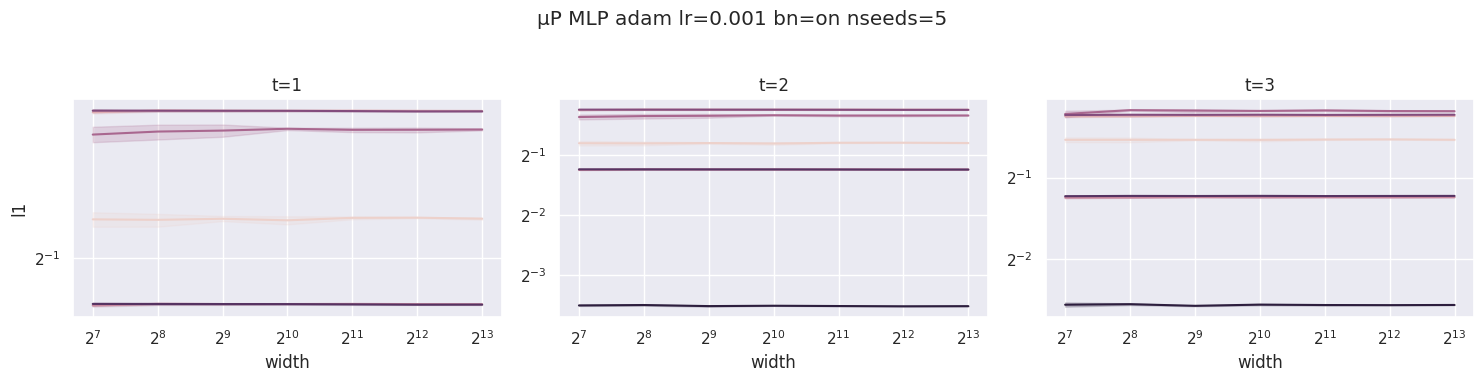

100%|██████████| 35/35 [00:08<00:00,  4.14it/s]


coord check plot saved to coord_checks/sp_cnn_sgd_lr0.1_nseeds5_bn0_coord.png


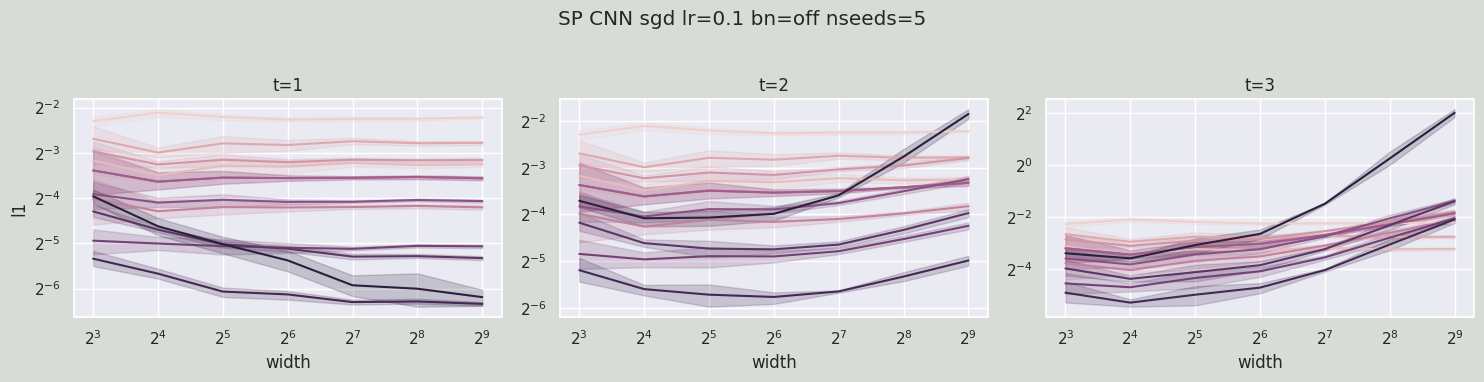

100%|██████████| 35/35 [00:12<00:00,  2.70it/s]


coord check plot saved to coord_checks/μp_cnn_sgd_lr0.1_nseeds5_bn0_coord.png


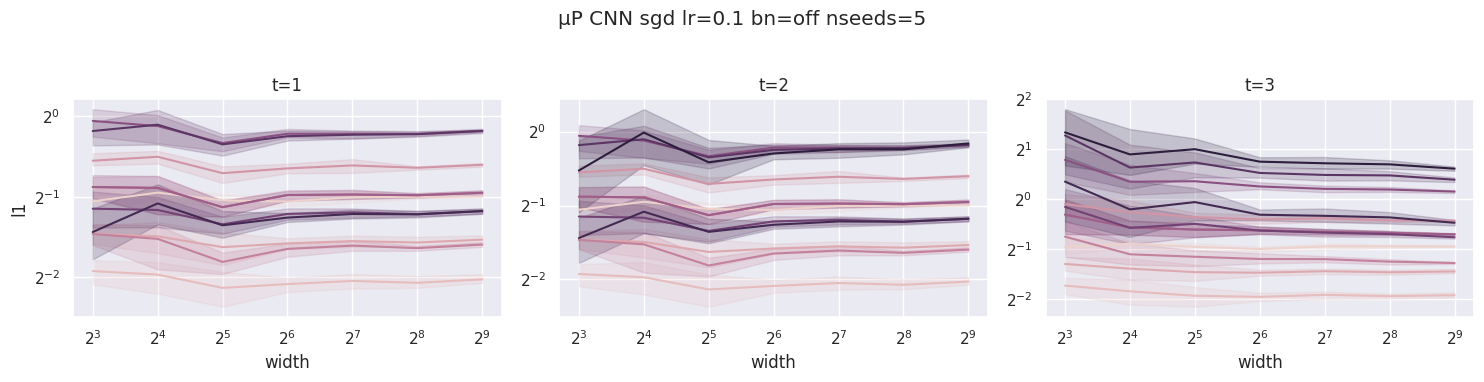

100%|██████████| 35/35 [00:05<00:00,  5.95it/s]


coord check plot saved to coord_checks/sp_cnn_sgd_lr0.1_nseeds5_bn1_coord.png


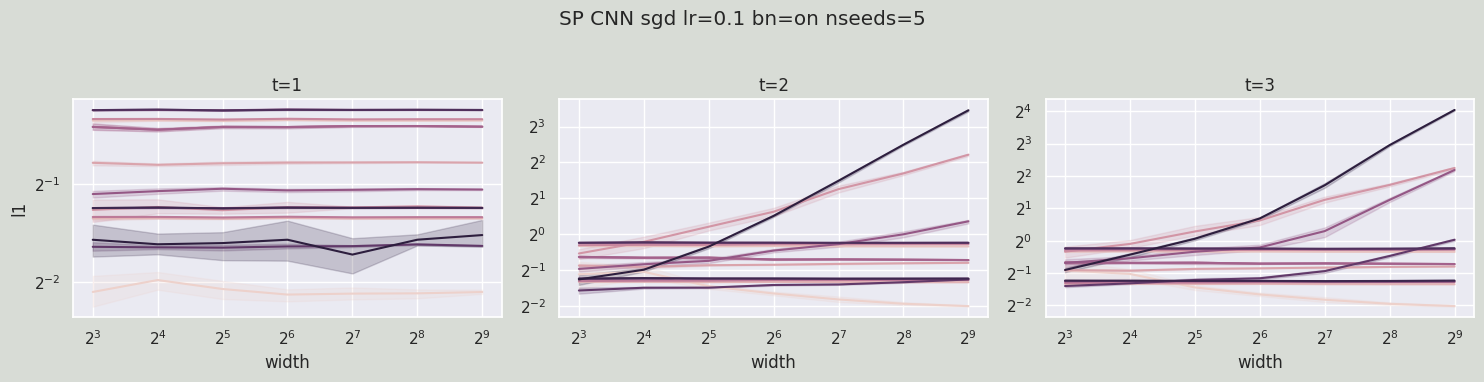

100%|██████████| 35/35 [00:13<00:00,  2.65it/s]


coord check plot saved to coord_checks/μp_cnn_sgd_lr0.1_nseeds5_bn1_coord.png


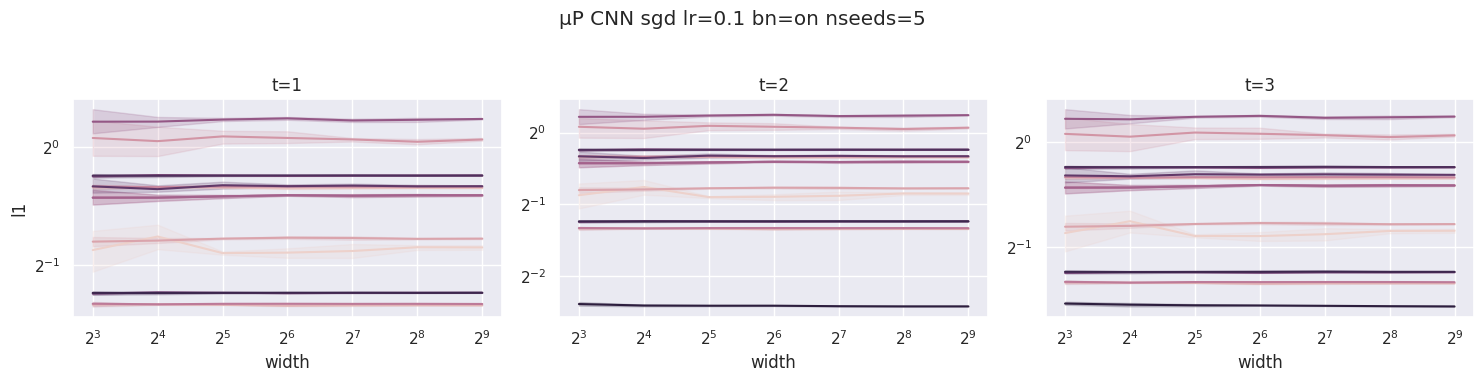

100%|██████████| 35/35 [00:06<00:00,  5.60it/s]


coord check plot saved to coord_checks/sp_cnn_adam_lr0.001_nseeds5_bn0_coord.png


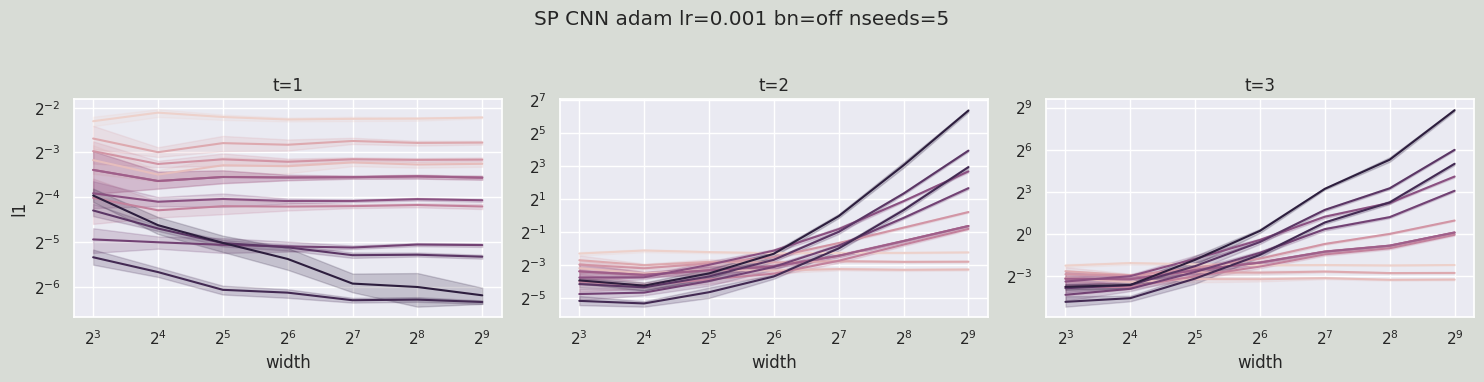

100%|██████████| 35/35 [00:13<00:00,  2.55it/s]


coord check plot saved to coord_checks/μp_cnn_adam_lr0.001_nseeds5_bn0_coord.png


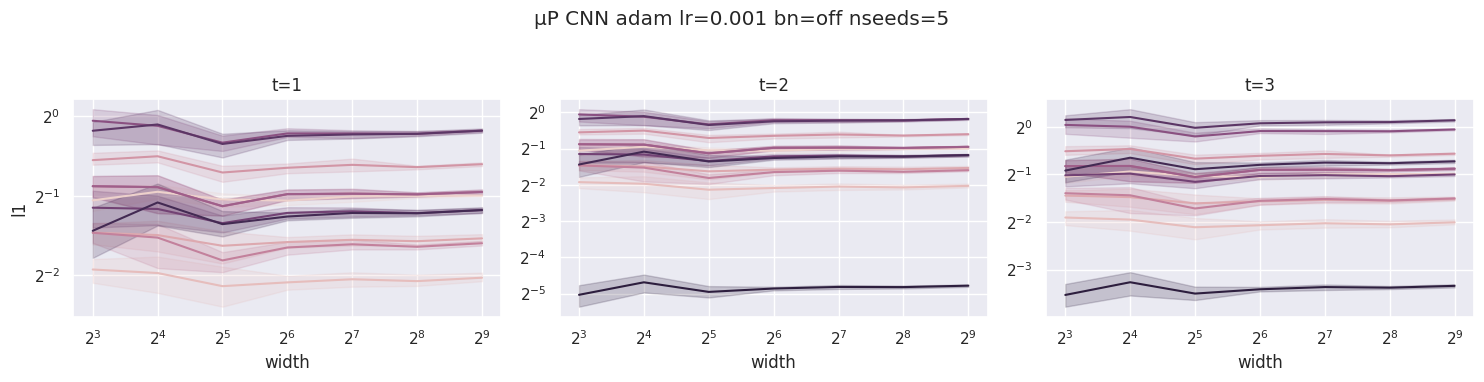

100%|██████████| 35/35 [00:07<00:00,  4.40it/s]


coord check plot saved to coord_checks/sp_cnn_adam_lr0.001_nseeds5_bn1_coord.png


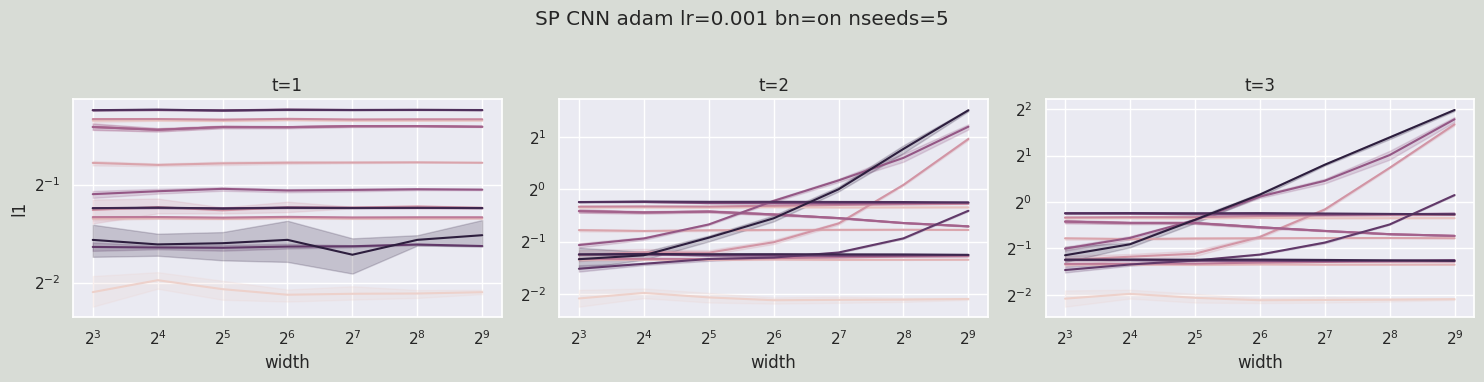

100%|██████████| 35/35 [00:14<00:00,  2.50it/s]


coord check plot saved to coord_checks/μp_cnn_adam_lr0.001_nseeds5_bn1_coord.png


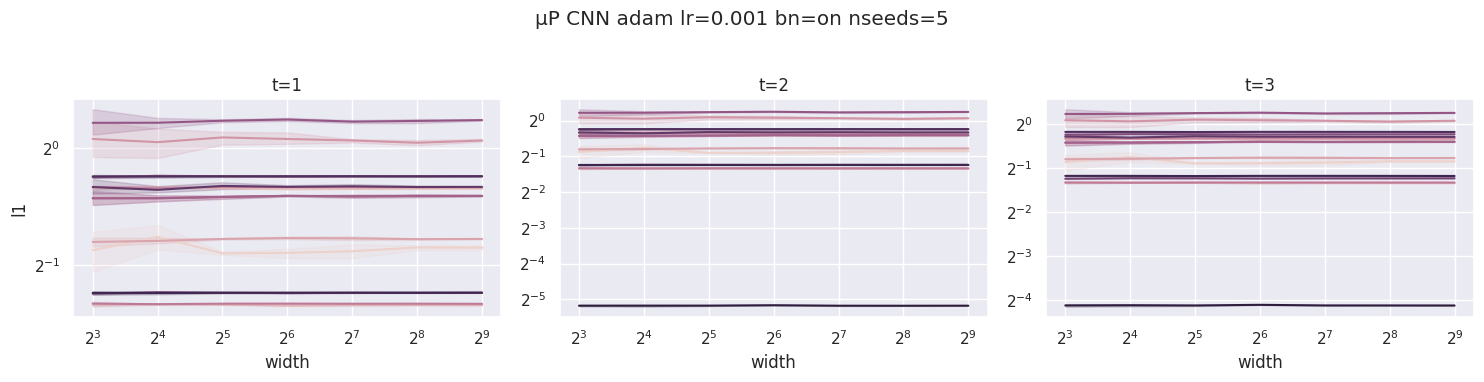

In [5]:
for arch, opt, bn, mup in product(['mlp', 'cnn'], ['sgd', 'adam'], [False, True], [False, True]):
    example_plot_coord_check(arch, opt, batchnorm=bn, mup=mup, nseeds=5, download_cifar=True, legend=None,
                    plotdir='coord_checks/')
    plt.show()

In [34]:
import copy
from tqdm import tqdm

arch = 'mlp'
widths = 2**np.arange(7, 14) if arch == 'mlp' else 2**np.arange(3, 10)
sp_models = get_lazy_models(arch, widths, mup=False, batchnorm=False, readout_zero_init=True)
train_loader = get_train_loader(batch_size=1, download=True)

cuda = torch.cuda.is_available()

flatten_input = True
flatten_output = False
lossfn = 'xent'

max_steps = 10

pretrained_sp_models = {}
for w, model_func in sp_models.items():
    model = model_func()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model = model.train()
    if cuda:
        model = model.cuda()
    for batch_idx, batch in tqdm(enumerate(train_loader)):
        if batch_idx > max_steps:
            break
        (data, target) = batch
        if cuda:
            data, target = data.cuda(), target.cuda()
        if flatten_input:
            data = data.view(data.size(0), -1)
        output = model(data)
        if flatten_output:
            output = output.view(-1, output.shape[-1])
        if lossfn == 'xent':
            loss = F.cross_entropy(output, target)
        elif lossfn == 'mse':
            loss = F.mse_loss(output, F.one_hot(target, num_classes=output.size(-1)).float())
        elif lossfn == 'nll':
            loss = F.nll_loss(output, target)
        else:
            raise NotImplementedError()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    pretrained_sp_models[w] = copy.deepcopy(model).cpu()

pretrained_sp_model_funcs = {w: (lambda: model) for w, model in pretrained_sp_models.items()}

11it [00:00, 745.91it/s]
11it [00:00, 656.97it/s]
11it [00:00, 830.82it/s]
11it [00:00, 911.05it/s]
11it [00:00, 48.35it/s]
11it [00:00, 215.65it/s]
11it [00:00, 76.04it/s]


In [24]:
for w, model in pretrained_sp_models.items():
    for name, param in model.named_parameters():
        var = torch.var(param).item()
        b = -math.log(var) / math.log(w)
        print(f"Model Width {w} Param {name}: {'=' * 50}")
        print(f"Variance: {var}")
        print(f"B-Val: {b}")
        print(f"Meets muTune Criteria: {b > 0.5}")

Model Width 128 Param 0.weight: ==================================================
Variance: 0.00012143672211095691
B-Val: 1.8582153750289458
Meets muTune Criteria: True
Model Width 128 Param 0.bias: ==================================================
Variance: 0.00012205616076244041
B-Val: 1.857166751831947
Meets muTune Criteria: True
Model Width 128 Param 2.weight: ==================================================
Variance: 0.0026119921822100878
B-Val: 1.2258048151158982
Meets muTune Criteria: True
Model Width 128 Param 2.bias: ==================================================
Variance: 0.003067244775593281
B-Val: 1.1926915688498674
Meets muTune Criteria: True
Model Width 128 Param 4.weight: ==================================================
Variance: 0.002623629989102483
B-Val: 1.224888573405694
Meets muTune Criteria: True
Model Width 128 Param 4.bias: ==================================================
Variance: 0.0021403844002634287
B-Val: 1.2668449093354126
Meets muTune Criteria:

100%|██████████| 175/175 [00:11<00:00, 15.23it/s]


coord check plot saved to sp_finetune_coord_checks/sp_mlp_adam_lr0.001_nseeds25_bn0_coord.png


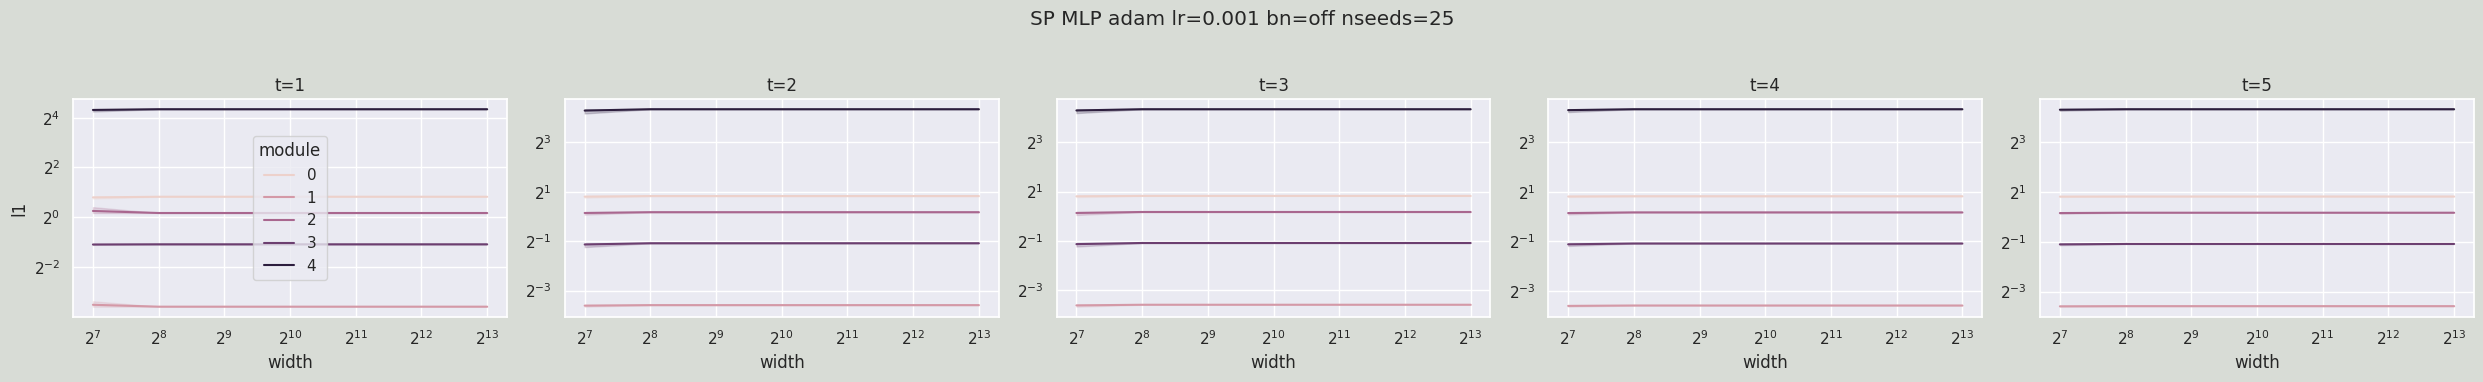

In [35]:
nseeds = 25
nsteps = 5 
batch_norm = False
legend = True
name_contains = None
name_not_contains = None
batchnorm = False
lr = 1e-3
mup = False
optimizer = "adam"
plotdir = "sp_finetune_coord_checks/"

df = get_coord_data(pretrained_sp_model_funcs, train_loader, mup=mup, lr=lr, optimizer=optimizer, flatten_input=arch == 'mlp', nseeds=nseeds, nsteps=nsteps, dict_in_out=False)

prm = 'μP' if mup else 'SP'
bn = 'on' if batchnorm else 'off'
if lr is None:
    lr = 0.1 if optimizer == 'sgd' else 1e-3
output_data = plot_coord_data(df, legend=legend,
    name_contains=name_contains, name_not_contains=name_not_contains, 
    save_to=os.path.join(plotdir, f'{prm.lower()}_{arch}_{optimizer}_lr{lr}_nseeds{nseeds}_bn{int(batchnorm)}_coord.png'),
    suptitle=f'{prm} {arch.upper()} {optimizer} lr={lr} bn={bn} nseeds={nseeds}',
    face_color='xkcd:light grey' if not mup else None)

100%|██████████| 35/35 [00:03<00:00,  9.36it/s]


coord check plot saved to sp_coord_checks/sp_mlp_adam_lr0.001_nseeds5_bn0_coord.png


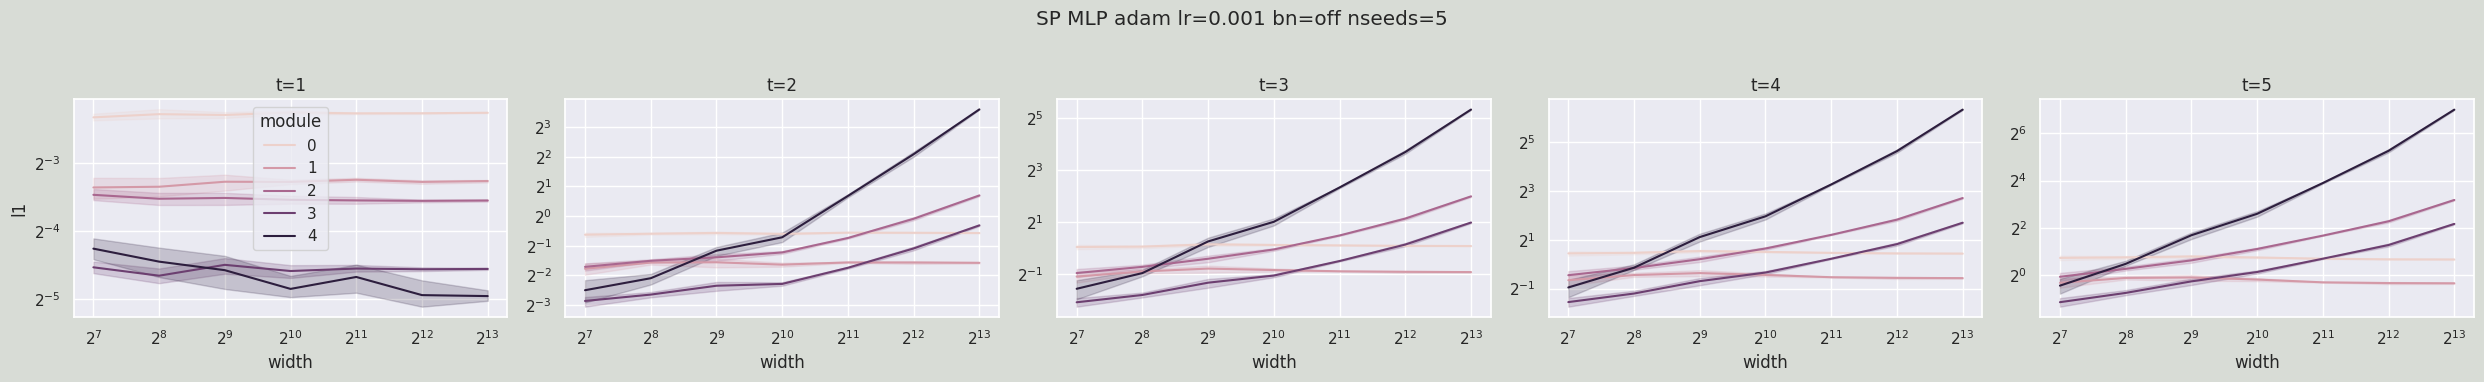

In [32]:
nseeds = 5
nsteps = 5 
batch_norm = False
legend = True
name_contains = None
name_not_contains = None
batchnorm = False
lr = 1e-3
optimizer = "adam"
mup = False
plotdir = "sp_coord_checks/"

df = get_coord_data(sp_models, train_loader, mup=mup, lr=lr, optimizer=optimizer, flatten_input=arch == 'mlp', nseeds=nseeds, nsteps=nsteps, dict_in_out=False)

prm = 'μP' if mup else 'SP'
bn = 'on' if batchnorm else 'off'
if lr is None:
    lr = 0.1 if optimizer == 'sgd' else 1e-3
output_data = plot_coord_data(df, legend=legend,
    name_contains=name_contains, name_not_contains=name_not_contains, 
    save_to=os.path.join(plotdir, f'{prm.lower()}_{arch}_{optimizer}_lr{lr}_nseeds{nseeds}_bn{int(batchnorm)}_coord.png'),
    suptitle=f'{prm} {arch.upper()} {optimizer} lr={lr} bn={bn} nseeds={nseeds}',
    face_color='xkcd:light grey' if not mup else None)